## Imports

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ! pip install aif360
# ! pip install cvxpy
# ! pip install BlackBoxAuditing

# import aif360
!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: numpy 1.26.2
Uninstalling numpy-1.26.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.10/dist-packages/numpy-1.26.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.26.2
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 

In [12]:
# Record the start time
start_time = time.time()

## Fairness metrics and functions


In [13]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [14]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [15]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=365)

    cv = StratifiedKFold(n_splits=5, random_state=365, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [16]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [17]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [18]:
# choose dataset
DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME='CREDIT_SEX'
#DATASET_NAME = 'BANK_AGE'



In [19]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv


Saving adult.csv to adult.csv
User uploaded file "adult.csv" with length 4104734 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [20]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('../input/adult-census-income/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('../input/compastwoyears/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

## Data_Visualization

In [21]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(6396, 15) (1112, 15) (13984, 15) (8670, 15)


In [22]:
maximum = max(orig_data_zero_priv.shape,orig_data_zero_non_priv.shape,orig_data_one_priv.shape,orig_data_one_non_priv.shape)
if maximum == orig_data_zero_priv.shape:
    print("orig_data_zero_priv is maximum")
if maximum == orig_data_zero_non_priv.shape:
    print("orig_data_zero_non_priv is maximum")
if maximum == orig_data_one_priv.shape:
    print("orig_data_one_priv is maximum")
if maximum == orig_data_one_non_priv.shape:
    print("orig_data_one_non_priv is maximum")

orig_data_zero_priv is maximum


In [23]:
maximum = maximum[0]
print(maximum)

13984


In [24]:
orig_data_zero_priv.shape[0]

13984

In [25]:
orig_data_one_non_priv

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,0,0,3683,20,United-States,1
7,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,0,0,3004,35,United-States,1
9,52,Private,129177,Bachelors,13,Widowed,Other-service,Not-in-family,White,0,0,2824,20,United-States,1
25,59,Self-emp-inc,107287,10th,6,Widowed,Exec-managerial,Unmarried,White,0,0,2559,50,United-States,1
29,63,Federal-gov,39181,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,0,0,2559,60,United-States,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30057,51,Local-gov,203334,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,0,0,0,45,United-States,1
30117,50,Private,208630,Masters,14,Divorced,Sales,Not-in-family,White,0,0,0,50,United-States,1
30125,46,Private,42972,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,0,0,0,22,United-States,1
30143,34,Private,160216,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,0,0,0,55,United-States,1


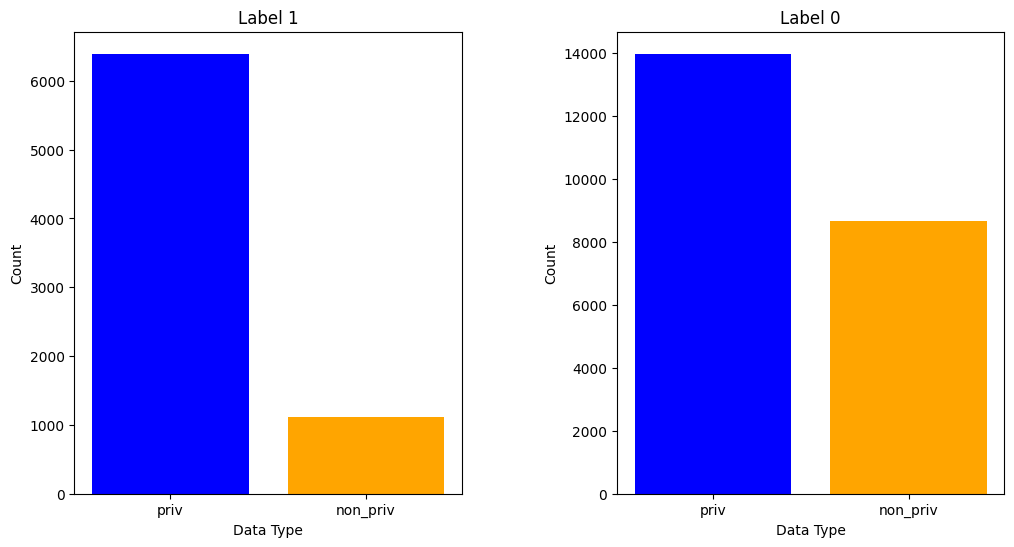

In [26]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

In [27]:
orig_data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,0,0,3770,45,United-States,0
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,1,0,0,40,United-States,0
30158,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,0,0,0,38,United-States,0
30159,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0,0,40,United-States,1
30160,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,0,0,0,40,United-States,0


In [28]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [29]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[4317  214]
 [ 729  773]] 
accuracy:  0.8436930217139068 precision:  0.7831813576494427 recall:  0.5146471371504661 fpr:  0.04723019201059369 tpr:  0.5146471371504661 fn+fp 943
performance for 0 sub-group:
conf matrix:
  [[1719   20]
 [ 125   97]] 
accuracy:  0.9260581336053034 precision:  0.8290598290598291 recall:  0.4369369369369369 fpr:  0.011500862564692352 tpr:  0.4369369369369369 fn+fp 145
performance for 1 sub-group:
conf matrix:
  [[2598  194]
 [ 604  676]] 
accuracy:  0.8040275049115914 precision:  0.7770114942528735 recall:  0.528125 fpr:  0.06948424068767908 tpr:  0.528125 fn+fp 798
bias metrics:
equal opportunity for tpr: (close to 0) 0.09118806306306304
equal opportunity for fpr: (close to 0) 0.057983378122986734
avarage absolute odds difference: (close to 0) 0.07458572059302489
statistical parity difference: (close to 0)  0.762917933130699
disparate_impact: (close to 1)  0.1185410334346504

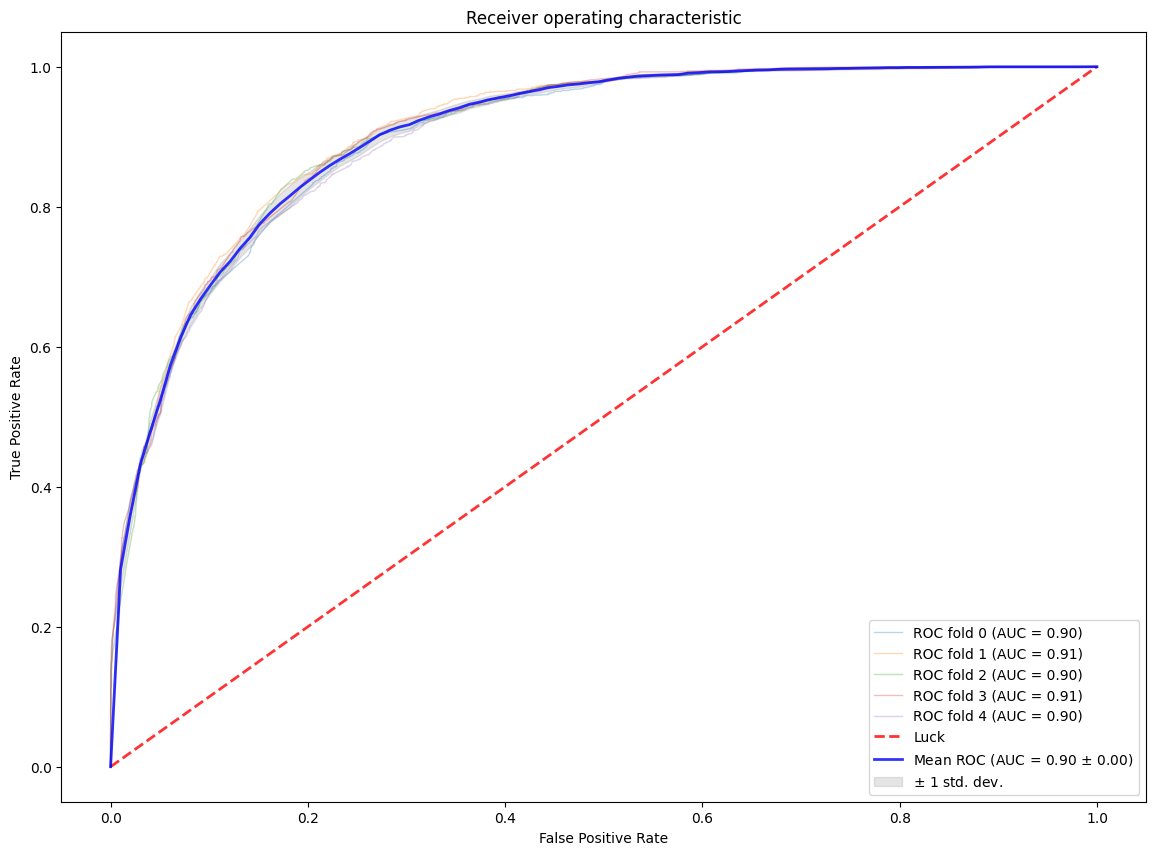

Accaracy list :  [0.8436930217139068, 0.8458478368970661, 0.8486405835543767, 0.8423408488063661, 0.8395225464190982]
equal opportunity for tpr :  [0.09118806306306304, 0.13454572585007368, 0.1174207995784759, 0.1410350678733031, 0.10501905680304913]
equal opportunity for fpr :  [0.057983378122986734, 0.05965288175262877, 0.04387695806751936, 0.06294866097842124, 0.05948317893710385]
odds difference list :  [0.07458572059302489, 0.09709930380135123, 0.08064887882299762, 0.10199186442586217, 0.0822511178700765]
The mean accuracy is  0.844 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.118 ± 0.018
The mean equal opportunity for fpr: (close to 0) 0.057 ± 0.007
The mean odds difference: (close to 0) 0.087 ± 0.010
The mean parity difference: (close to 0) 0.769 ± 0.017
The mean disperate impact: (close to 1) 0.115 ± 0.008


In [30]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig)

  ## CTGANfor each group

In [31]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1


print(zero_priv_toincrease,zero_nonpriv_toincresed,one_priv_toincresed,one_nonpriv_toincresed)

0 5314 7588 12872


# CTGAN On Priv Target Group

In [32]:
from ctgan import CTGAN

# Fit CTGAN for orig_data_zero_priv

ctgan_zero_priv = CTGAN(verbose=True)
ctgan_zero_priv.fit(orig_data_zero_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_zero_non_priv

ctgan_zero_nonpriv = CTGAN(verbose=True)
ctgan_zero_nonpriv.fit(orig_data_zero_non_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_priv

ctgan_one_priv = CTGAN(verbose=True)
ctgan_one_priv.fit(orig_data_one_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_non_priv

ctgan_one_nonpriv = CTGAN(verbose=True)
ctgan_one_nonpriv.fit(orig_data_one_non_priv , CATEGORICAL, epochs = 200)



Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b05900cb1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error
Gen. (-0.47) | Discrim. (-0.16): 100%|██████████| 200/200 [14:16<00:00,  4.28s/it]
Gen. (-0.59) | Discrim. (-0.19): 100%|██████████| 200/200 [08:33<00:00,  2.57s/it]
Gen. (-0.

In [33]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1

#create samples using ctgan with zero_priv
zero_priv_samples = ctgan_zero_priv.sample(zero_priv_toincrease)


#create samples using ctgan with zero_nonpriv
zero_nonpriv_samples = ctgan_zero_nonpriv.sample(zero_nonpriv_toincresed)


#create samples using ctgan with one_priv
one_priv_samples = ctgan_one_priv.sample(one_priv_toincresed)


#create samples using ctgan with zero_priv
one_nonpriv_samples = ctgan_one_nonpriv.sample(one_nonpriv_toincresed)



In [34]:
Upsampled_Dataset = pd.concat([orig_dataset, zero_priv_samples, zero_nonpriv_samples, one_priv_samples, one_nonpriv_samples], ignore_index=True)

Upsampled_Dataset = Upsampled_Dataset.reset_index()


In [35]:
Upsampled_Dataset

,index,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0
1,1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0
2,2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0
3,3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,0,0,3770,45,United-States,0
4,4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55931,55931,29,Private,500170,Some-college,7,Married-civ-spouse,Other-service,Unmarried,White,0,17243,3,50,Vietnam,1
55932,55932,35,Self-emp-not-inc,262717,Masters,14,Never-married,Machine-op-inspct,Wife,White,0,11901,45,38,Germany,1
55933,55933,33,Self-emp-inc,401799,Bachelors,8,Divorced,Prof-specialty,Unmarried,White,0,24,1275,40,United-States,1
55934,55934,37,Private,151289,Some-college,8,Never-married,Prof-specialty,Not-in-family,White,0,11528,-21,1,United-States,1


In [36]:
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]

Upsampled_df_features = encoder.transform(Upsampled_df_features)
Upsampled_df_features

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,82,0.218792,132870,0.164329,9,0.096735,0.485220,0.106523,0.263718,0,0,4356,18,0.254327
1,54,0.218792,140359,0.062837,4,0.107262,0.124619,0.066314,0.263718,0,0,3900,40,0.254327
2,41,0.218792,264663,0.200060,10,0.070288,0.448489,0.014330,0.263718,0,0,3900,40,0.254327
3,34,0.218792,216864,0.164329,9,0.107262,0.041096,0.066314,0.263718,0,0,3770,45,0.254327
4,38,0.218792,150601,0.071951,6,0.070288,0.133835,0.066314,0.263718,1,0,3770,40,0.254327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55931,29,0.218792,500170,0.200060,7,0.454959,0.041096,0.066314,0.263718,0,17243,3,50,0.080197
55932,35,0.285714,262717,0.564229,14,0.048324,0.124619,0.493599,0.263718,0,11901,45,38,0.343748
55933,33,0.558659,401799,0.421491,8,0.107262,0.448489,0.066314,0.263718,0,24,1275,40,0.254327
55934,37,0.218792,151289,0.200060,8,0.048324,0.448489,0.106523,0.263718,0,11528,-21,1,0.254327


performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[5117  477]
 [ 669 4925]] 
accuracy:  0.8975688237397211 precision:  0.9116993706034802 recall:  0.8804075795495173 fpr:  0.08526993207007508 tpr:  0.8804075795495173 fn+fp 1146
performance for 0 sub-group:
conf matrix:
  [[2670  100]
 [ 140 2652]] 
accuracy:  0.9568500539374326 precision:  0.9636627906976745 recall:  0.9498567335243553 fpr:  0.036101083032490974 tpr:  0.9498567335243553 fn+fp 240
performance for 1 sub-group:
conf matrix:
  [[2447  377]
 [ 529 2273]] 
accuracy:  0.8389619623178102 precision:  0.8577358490566038 recall:  0.8112062812276946 fpr:  0.1334985835694051 tpr:  0.8112062812276946 fn+fp 906
bias metrics:
equal opportunity for tpr: (close to 0) 0.13865045229666073
equal opportunity for fpr: (close to 0) 0.09739750053691414
avarage absolute odds difference: (close to 0) 0.11802397641678744
statistical parity difference: (close to 0)  0.01888189559422432
disparate_impact: (close to 1

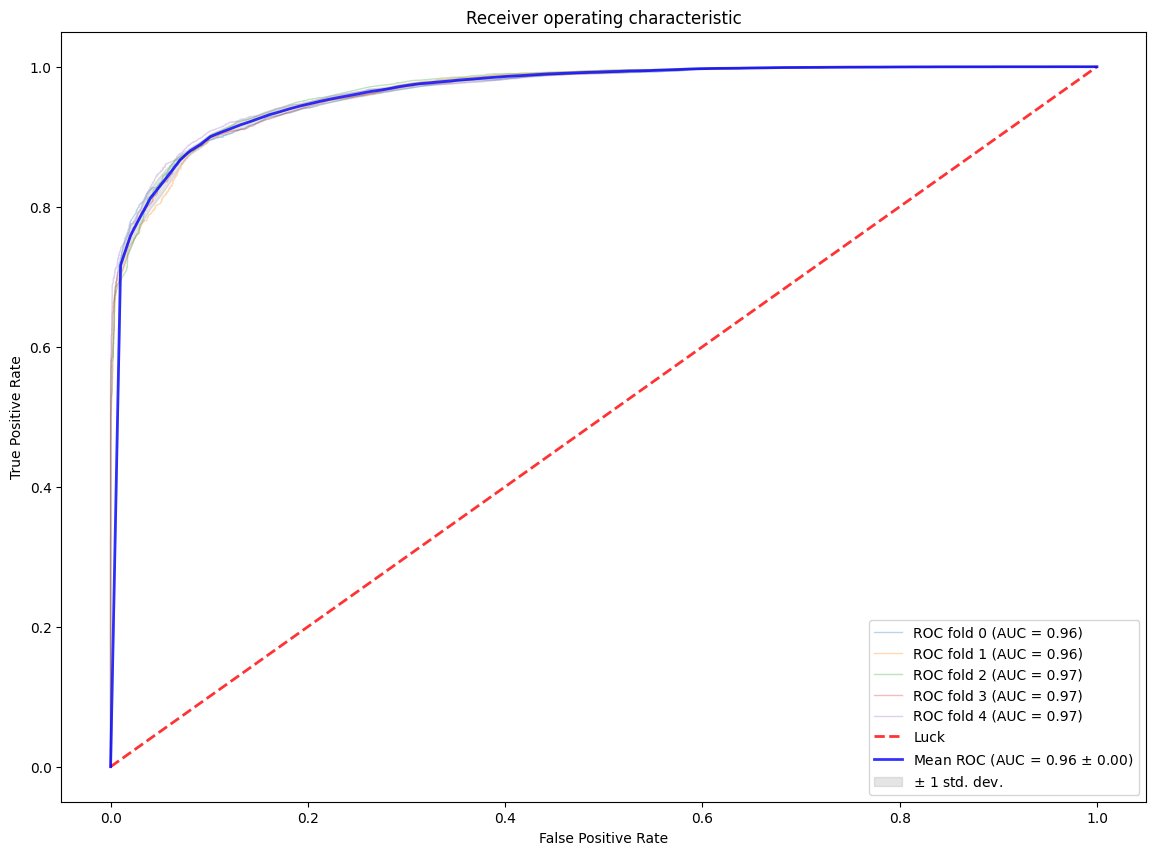

Accaracy list :  [0.8975688237397211, 0.8956824886028426, 0.9003307410387057, 0.8986323411102172, 0.9041744882452847]
equal opportunity for tpr :  [0.13865045229666073, 0.16696522567812166, 0.17823798550921088, 0.13789350812055534, 0.1263081535622822]
equal opportunity for fpr :  [0.09739750053691414, 0.06523043171427695, 0.06072867765129432, 0.09964349376114082, 0.09444928242330311]
odds difference list :  [0.11802397641678744, 0.1160978286961993, 0.1194833315802526, 0.11876850094084808, 0.11037871799279265]
The mean accuracy is  0.899 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.150 ± 0.020
The mean equal opportunity for fpr: (close to 0) 0.083 ± 0.017
The mean odds difference: (close to 0) 0.117 ± 0.003
The mean parity difference: (close to 0) 0.035 ± 0.019
The mean disperate impact: (close to 1) 0.451 ± 0.026


In [37]:
y_upsampled = Upsampled_Dataset[TARGET_COL]

# Check fairness metrics again
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Store metrics values
# op_diff_values.append(mean(debias_op_diff))
# dis_impact_values.append(mean(debias_dis_impact))
# debias_acc_values.append(mean(debias_acc))
# debias_odds_diff_values.append(mean(debias_od_diff))
# alfa_counter += 1
# print('alfa counter is :',alfa_counter)
# print ('debias_op_diff is {} , orig_op_diff is {}'.format(mean(debias_op_diff), mean(orig_op_diff)))
# print ('debias_dis_impact is {} , orig_dis_impact is {}'.format(mean(debias_dis_impact), mean(orig_dis_impact)) )

In [38]:
#Based on class
Upsampled_Dataset_one , Upsampled_Dataset_zero = [x for _, x in Upsampled_Dataset.groupby(Upsampled_Dataset[TARGET_COL] == 0)]

#Based on priv feature
Upsampled_df_one_priv, Upsampled_df_one_non_priv = [x for _, x in Upsampled_Dataset_one.groupby(Upsampled_Dataset_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
Upsampled_df_zero_priv, Upsampled_df_zero_non_priv = [x for _, x in Upsampled_Dataset_zero.groupby(Upsampled_Dataset_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(Upsampled_df_one_priv.shape,Upsampled_df_one_non_priv.shape,Upsampled_df_zero_priv.shape,Upsampled_df_zero_non_priv.shape)

(13984, 16) (13984, 16) (13984, 16) (13984, 16)


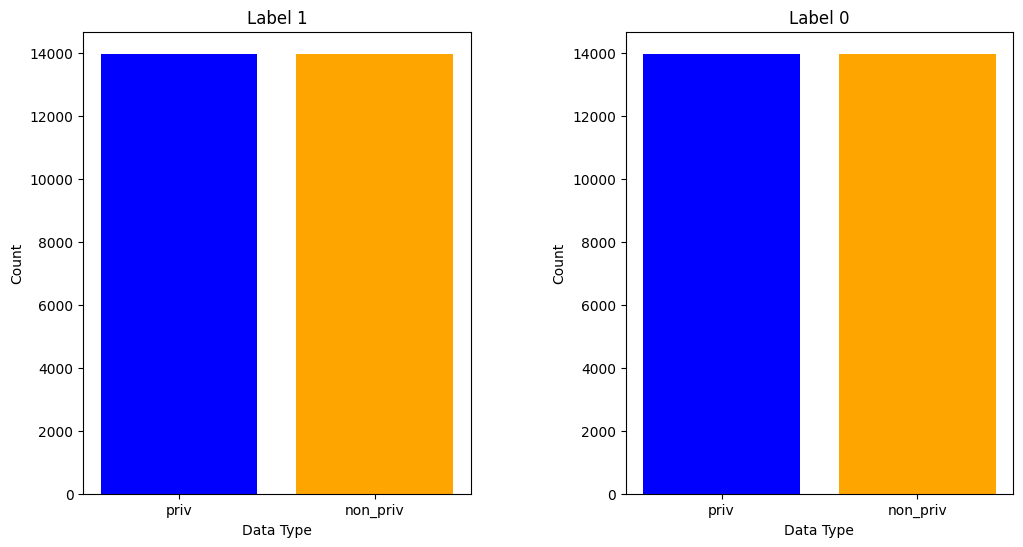

In [39]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [Upsampled_df_one_priv.shape[0], Upsampled_df_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [Upsampled_df_zero_priv.shape[0], Upsampled_df_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[5117  477]
 [ 669 4925]] 
accuracy:  0.8975688237397211 precision:  0.9116993706034802 recall:  0.8804075795495173 fpr:  0.08526993207007508 tpr:  0.8804075795495173 fn+fp 1146
performance for 0 sub-group:
conf matrix:
  [[2670  100]
 [ 140 2652]] 
accuracy:  0.9568500539374326 precision:  0.9636627906976745 recall:  0.9498567335243553 fpr:  0.036101083032490974 tpr:  0.9498567335243553 fn+fp 240
performance for 1 sub-group:
conf matrix:
  [[2447  377]
 [ 529 2273]] 
accuracy:  0.8389619623178102 precision:  0.8577358490566038 recall:  0.8112062812276946 fpr:  0.1334985835694051 tpr:  0.8112062812276946 fn+fp 906
bias metrics:
equal opportunity for tpr: (close to 0) 0.13865045229666073
equal opportunity for fpr: (close to 0) 0.09739750053691414
avarage absolute odds difference: (close to 0) 0.11802397641678744
statistical parity difference: (close to 0)  0.01888189559422432
disparate_impact: (close to 1

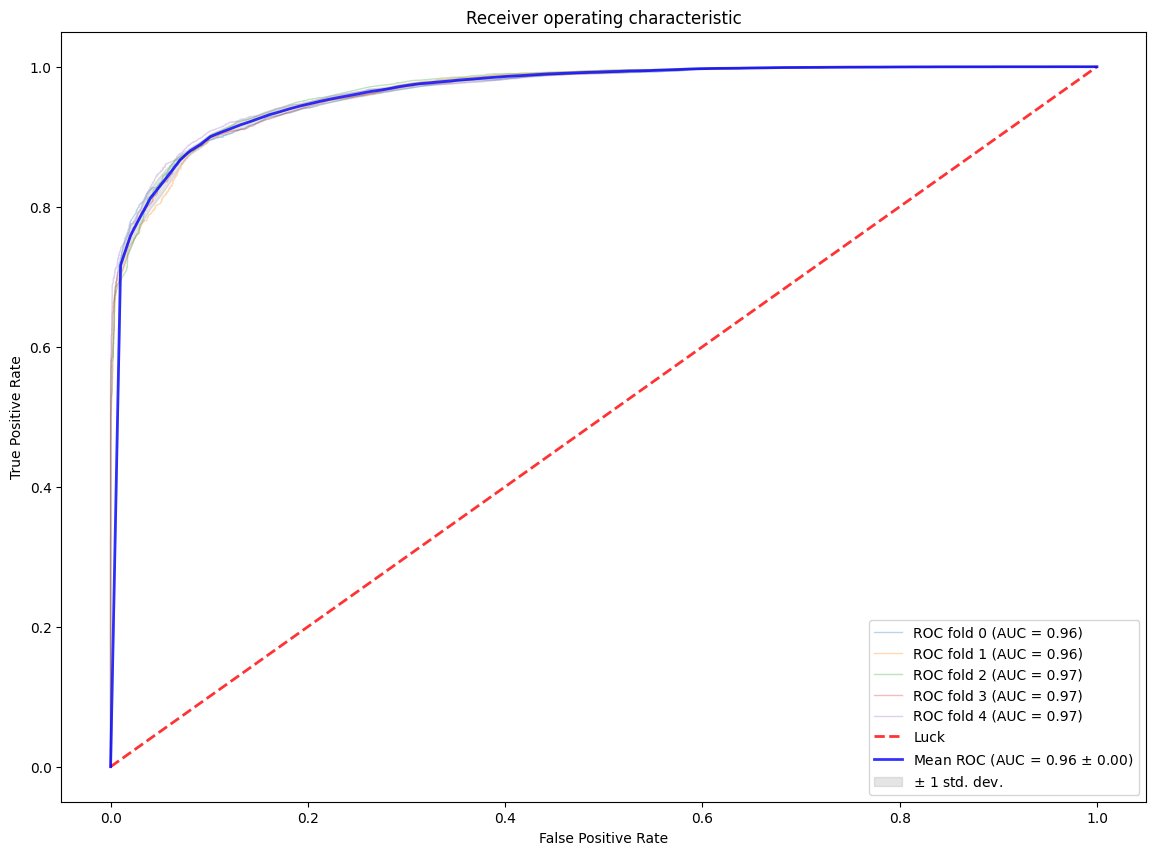

Accaracy list :  [0.8975688237397211, 0.8956824886028426, 0.9003307410387057, 0.8986323411102172, 0.9041744882452847]
equal opportunity for tpr :  [0.13865045229666073, 0.16696522567812166, 0.17823798550921088, 0.13789350812055534, 0.1263081535622822]
equal opportunity for fpr :  [0.09739750053691414, 0.06523043171427695, 0.06072867765129432, 0.09964349376114082, 0.09444928242330311]
odds difference list :  [0.11802397641678744, 0.1160978286961993, 0.1194833315802526, 0.11876850094084808, 0.11037871799279265]
The mean accuracy is  0.899 ± 0.003
The mean equal opportunity for tpr: (close to 0) 0.150 ± 0.020
The mean equal opportunity for fpr: (close to 0) 0.083 ± 0.017
The mean odds difference: (close to 0) 0.117 ± 0.003
The mean parity difference: (close to 0) 0.035 ± 0.019
The mean disperate impact: (close to 1) 0.451 ± 0.026


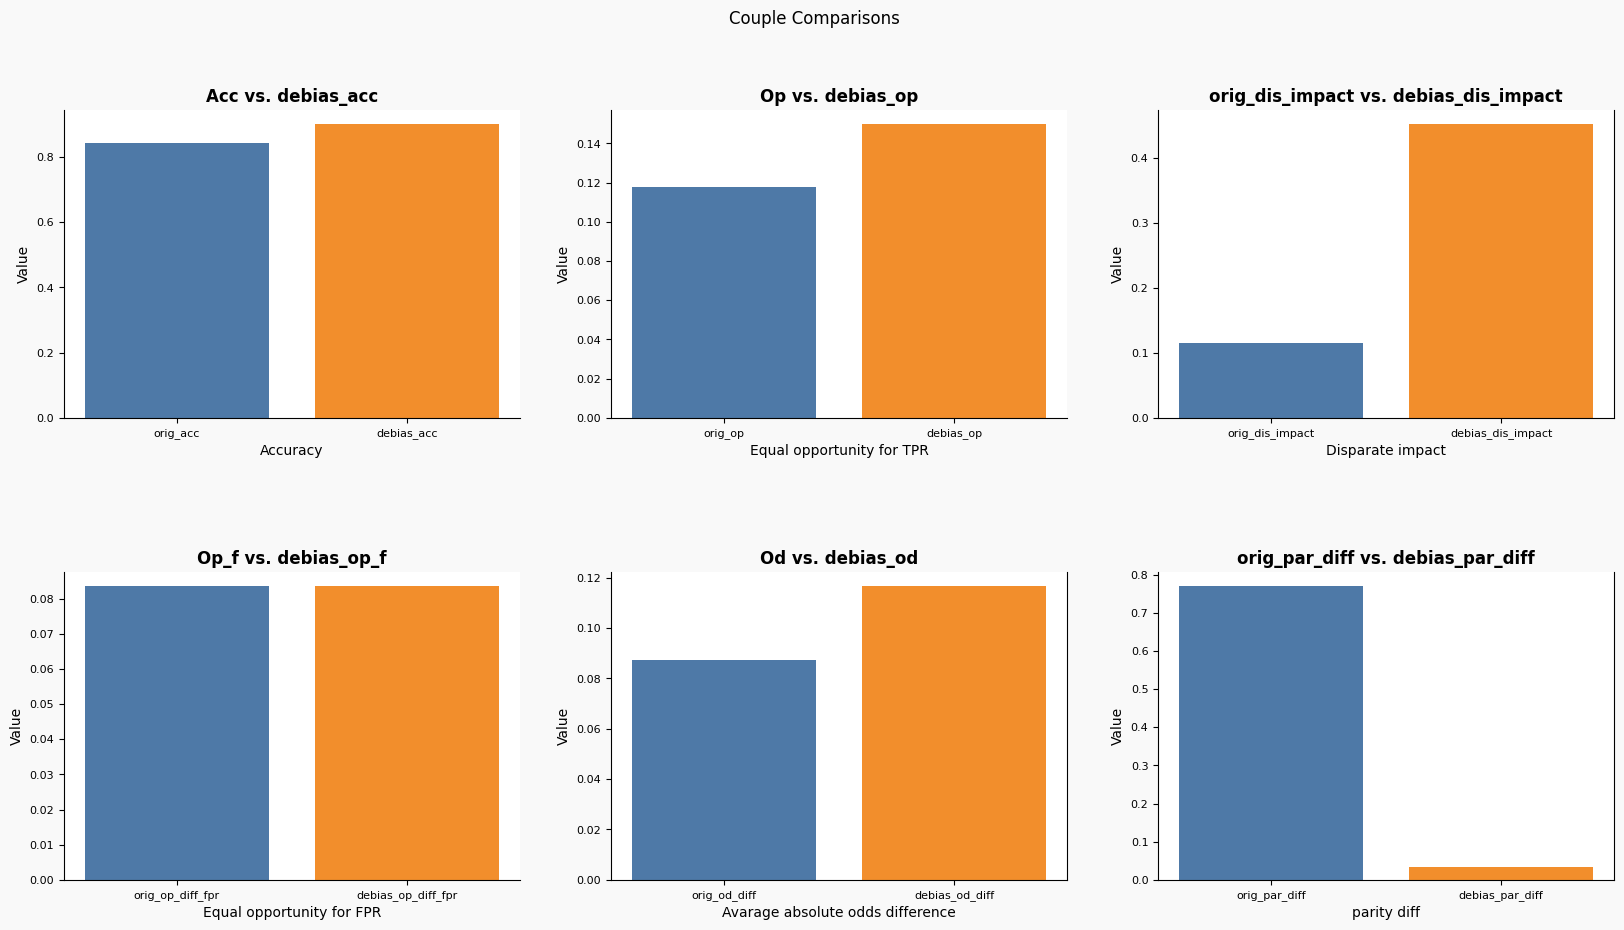

In [40]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines



In [41]:
# Record the end time
end_time = time.time()

In [42]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 32.3729 minutes
